<a href="https://colab.research.google.com/github/marco-milanesi/social-project/blob/main/social-project/src/Mountain%20Car%20IRL/IRL_mountain_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of Inverse RL algorithm on Mountain Car env:

This code is an application of IRL algorithm on Mountain Car environment in the case:
1. Where the dynamics of the environment are not known to the agent. (No transition probabilities)
2. The agent uses expert trajectories data to learn the "Reward Function".
For  more details on the algorithm, refer to Case 3 of [Algorithms for Inverse Reinforcement Learning](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf) paper.

## Mountain Car Environment:
###  Properties:
1. Continuous State Space Environment.
    - state = [position/pos, velocity/vel]
    - pos.min_position = -1.2
    - pos.max_position = 0.6
    - vel.max_speed = 0.07
    - env.goal_position = 0.5


2. Discrete Action Space
    - self.action_space = spaces.Discrete(3)
    - Implies it has three actions.
    - 0- accelerates in the left direction
    - 1 - zero acceleration 
    - 2- accelerates in the right direction
    - acceleration= 0.001 units

###  Function Approximators:
1. Linear Function Approximators are used for the RL and IRL code blocks instead of neural networks.

In [42]:
pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 80.1 MB/s 


In [22]:
'''
This python file contains the code for generation of surface graphs of value functions and other statistical graphs.
This does not include reward function graphs.
'''

import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)
    return fig1, fig2, fig3


In [40]:
"""
This code basically contains 
    a) The code/functions of RL part of the IRL code.
        * This RL code takes in reward function and returns the new learnt policy.
    b) The code for generating expert polices and trajectories.
        ** The expert policies are generally displayed by some human or machine who is an expert in that activity. 
        Here, we used a different approach to learn expert policy. 
        We used RL algorithm (Q-learning with Linear Function Approximation) to train an agent to be an expert in Mountain Car env. 
        And then, that learnt agent is considered as an expert and the expert trajectories are generated by that agent.
"""
import gym
import itertools
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm



# For Q learning code
# Container for feature vector of RL part
def state_featurizer(normalized_data):
    featurizer=sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
    ])
    featurizer.fit(normalized_data)
    return featurizer


class Estimator():
    """
    Value function approximator
    """
    
    def __init__(self,env,scaler,featurizer):
        # We create individual models for each action instead of getting 
        # output as a nA*1 vector.
        self.models=[]
        self.env = env
        self.scaler = scaler
        self.featurizer=featurizer
        for _ in range(3):
            model=SGDRegressor(learning_rate="constant", max_iter = 200000000, tol= 1e-10)
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(self.env.reset())],[0])
            self.models.append(model)
    
    def featurize_state(self, state):
        
        scaled= self.scaler.transform([state])
        featurized= self.featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        # Makes value function predictions.
        
        feature_vec= self.featurize_state(s)
        if not a:
            return np.array([m.predict([feature_vec]) for m in self.models])
        else:
            return self.models[a].predict([feature_vec])      #.predict module is inbuilt in SGDRegresssor
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        feature_vec = self.featurize_state(s)
        (self.models[a]).partial_fit([feature_vec], [y])
        

def epsilon_greedy_policy(observation,estimator, epsilon, nA):
    # Returns a e-greeedy policy
    
    A=np.ones(nA, dtype=float) * epsilon / nA
    q_values=  estimator.predict(observation)
    best_action=np.argmax(q_values)
    A[best_action] += (1.0 - epsilon)
    return A

def greedy_policy(estimator, nA):
    # returns a function for generating greedy policy for a state/observation.
    def policy_maker(observation):
        A=np.zeros(nA, dtype=float)
        q_values=  estimator.predict(observation)
        best_action=np.argmax(q_values)
        A[best_action] += (1.0)
        return A
    return policy_maker

def policy_f(env, scaler,featurizer,print_ep_lens):
    '''
    Main Calling Function for generating expert policy.
    ** Read the multi-line comment at the starting of this file to gain understanding.
    
    Args:
        env: Gym environment
        scaler: Mean and variance of the state values.
        featurizer: The container used for generating expert trajectories.
        print_ep_stats: [Bool] Prints interation with no. of time steps required for completion
        
    Returns:
        a) Plots statisics of mountain car learning with inbuilt rewards in the gym environment.
        So that we are able to compare results with the mountain car learning with learnt reward function.
        b) Returns "Demostration By Expert" DBE policy.
    '''
    estimator= Estimator(env,scaler,featurizer)
    stats =  q_learning_best_policy(env, estimator, 200, epsilon = 0.0, print_ep_lens=False)
    print("___Plotting Learning Stats of the Agent____")
    plot_cost_to_go_mountain_car(env, estimator)
    plot_episode_stats(stats, smoothing_window=25)
    final_policy = greedy_policy(estimator, env.action_space.n)
    return final_policy, estimator
    

def q_learning(env, estimator, reward_fn, num_episodes, num_trajectory=0, discount_factor=1.0, epsilon=0.0, epsilon_decay=1.0, print_ep_details=False):
    """
    a) Given a reward function, this RL algorithm learns the policy for the environment.
    """
    d_vec=np.ones(num_episodes)*2000
    for i in tqdm(range(num_episodes)):
        state =env.reset()
        done= False
        
        '''Important: Breaking up the trajectory after 2000 timesteps,if not reached the goal during training.'''
        for d in range(2000):
            
            prob = epsilon_greedy_policy(state ,estimator, epsilon * epsilon_decay**i ,env.action_space.n)
            action = np.random.choice(np.arange(len(prob)), p=prob )
            step= env.step(action)
            
            next_state = step[0]
            done = step[2]
            if done:
                break
            reward = reward_fn(state)    
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)
            estimator.update(state,action,td_target)
            state=next_state
        if print_ep_details:    
            print("Episode {} completed in {} timesteps".format(i,d))
        d_vec[i] = d 
    return np.min(d_vec)     # Just for some experiments: Not used anywhere in the IRL code. 



def q_learning_best_policy(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.0, epsilon_decay=1.0, print_ep_lens=False):
    '''
    ** RL Code for the learning part of the expert agent. This does not take the reward function.
    It uses the default environment reward function.
    '''
    # Statistics during learning process
    stats= EpisodeStats(episode_lengths= np.zeros(num_episodes), episode_rewards = np.zeros(num_episodes))
    
    for i in tqdm(range(num_episodes)):
        state =env.reset()
        done= False
        d=0
        while not done:
            
            prob = epsilon_greedy_policy(state ,estimator, epsilon * epsilon_decay**i ,env.action_space.n)
            action = np.random.choice(np.arange(len(prob)), p=prob )
            next_state, reward, done, _ = env.step(action)
            
            stats.episode_rewards[i] += reward
            stats.episode_lengths[i] += 1
            
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)
            estimator.update(state,action,td_target)
            state=next_state
            d+=1
        if print_ep_lens:
             print("Episode {} completed in {} timesteps".format(i,d))
    
    return stats        


def q_learning_testing_rewards(env, estimator, reward_fn, num_episodes, discount_factor=1.0,
                               epsilon=0.0, epsilon_decay=1.0, render=False,ep_details=False):
    '''
    Given the reward function, The RL agent learns the best policy.
    (Used for generating final results to compare with learning with default handcrafted rewards.) 
    '''
    # Statistics during learning process
    stats= EpisodeStats(episode_lengths= np.zeros(num_episodes), episode_rewards = np.zeros(num_episodes))
    
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        d = 0
        
        while not done and d<=2000:
            
            prob = epsilon_greedy_policy(state ,estimator, epsilon * epsilon_decay**i ,env.action_space.n)
            action = np.random.choice(np.arange(len(prob)), p=prob )
            step= env.step(action)
            
            next_state = step[0]
            done = step[2]
            reward = reward_fn(state)
            if render:
                env.render()
            
            stats.episode_rewards[i] += reward
            stats.episode_lengths[i] += 1
            
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)
            estimator.update(state,action,td_target)
            state=next_state
            d+=1
        
        if ep_details:
            print("Episode {} completed in {} timesteps".format(i,d))   
    
    return stats        

def compare_results(env,estimator_f,estimator_dbe,num_test_trajs,epsilon_test=0.0):
    dbe_score=0
    imitator_score=0
    for network,point in [(estimator_dbe,1),(estimator_f,2)]: 
        tot_reward=np.zeros(num_test_trajs)
        for i in tqdm(range(num_test_trajs)):
            state=env.reset()
            done=False
            for t in range(2000):
                prob = epsilon_greedy_policy(state ,network, epsilon_test ,env.action_space.n)
                action= np.random.choice(np.arange(len(prob)),p=prob)
                next_state,reward,done,_= env.step(action)
                env.render()
                tot_reward[i]+=reward
                if done:
                    break
                state=next_state
                
        if point==1:
            dbe_score= np.sum(tot_reward)/num_test_trajs
        elif point==2:
            imitator_score = np.sum(tot_reward)/num_test_trajs
        else:
            print("Somethings wrong:(")
    
    plt.plot([1,2,3],[dbe_score]*3,label='DBE Score value')
    plt.plot([1,2,3],[imitator_score]*3,label='Imitator Score')
    plt.legend(loc='lower right')
    plt.xlabel("Just for reward visualization.[x axis is nothing]")
    plt.ylabel("Avg Reward")
    plt.show()
    env.close()
    print("Expert policy score  "+" | ",dbe_score)
    print("Imitator policy score"+" | ",imitator_score)
    return dbe_score, imitator_score


# Code

In [24]:
%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
from collections import defaultdict
import scipy

In [25]:
def normalization(env,observation_examples):
    """
    Calculates Mean and Variance of the state values
    
    Args:
        observation_examples: An array of 10000 random state::[position, velocity] values.
    Returns:
        Mean and variance of the state values.
    """
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(observation_examples)
    return scaler

In [26]:
def featurizer_function(normalized_data, featureVecDim):
    """
    Calculates Mean and Variance of the state values
    
    Args:
        normalized_data: An array of 10000 normalized state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
    Returns:
        Container for ϕ vector.
    """
    # Container for ϕ vector(Basis vector).[In the paper, they used 26 evenly spaced Gaussian shaped basis functions]
    featurizer_vector = sklearn.pipeline.FeatureUnion([
        ("rbf1",RBFSampler(gamma=0.5,n_components=10)),
        ("rbf2", RBFSampler(gamma=0.25, n_components=20)),
        ("rbf3", RBFSampler(gamma=0.1, n_components=20))
    ])
    
    # Reward dependency on position value only.
    position_vec = np.delete(normalized_data, 1,1)
    # Fit method defines the upper and lower limits of random offset and fits the data
    featurizer_vector.fit(position_vec)
    
    return featurizer_vector

In [27]:
def scaler_val(state,scaler):
    return (state[0]- scaler.mean_[0])/scaler.var_[0]

In [28]:
def UniformRandomPolicyGenerator(nA):
    # nA = number of actions
    def urpg(state):
        return np.ones(nA, dtype=float)/nA
    return urpg

In [29]:
def RandomVectorGenerator(featureVecDim):
    return 2*np.random.rand(featureVecDim)-1

In [30]:
def max_dict(dictionary):
    v_max=max(dictionary.values())
    for key, value in dictionary.items():
        if value == v_max:
            return key

In [31]:
def e_greedy_policy(estimator, nA,epsilon):
    def policy_maker(observation):
        A=np.ones(nA, dtype=float)*epsilon/nA
        q_values=  estimator.predict(observation)
        best_action=np.argmax(q_values)
        A[best_action] += (1.0-epsilon)
        return A
    return policy_maker

In [32]:
def reward(alpha_vec,featurizer_vector,scaler):
    def reward_fn(state):
        return np.dot(alpha_vec, featurizer_vector.transform([[scaler_val(state,scaler)]])[0])
    return reward_fn

In [33]:
def reward_plot(alpha_vec,featurizer_vector,scaler):
    x=np.linspace(-1.2,0.6,num=1000)
    i=0
    y=np.zeros(1000)
    for position in x:
        y[i] = np.dot(alpha_vec,featurizer_vector.transform([[(position-scaler.mean_[0])/scaler.var_[0]]])[0])
        i+=1
    #plt.plot(x,savitzky_golay(y),linewidth=2.0)
    plt.plot(x,y,linewidth=2.0) 
    plt.xlabel("Position")
    plt.ylabel("Reward")
    plt.title("Reward function")
    plt.show()

In [34]:
"""
Some experiments were done to smoothen up the alpha vector, if somebody would like to try.
I got some results,of them some were good but it resulted in diverging solutions many times.
"""
def smooth(y, box_pts=4):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def savitzky_golay(y, window_size=51, order=5, deriv=0, rate=1):

    import numpy as np
    from math import factorial
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [35]:
def ValueFunctionGenerator(env,alpha_vec, policy,featurizer_vec,scaler,featureVecDim, num_trajectories,discount_factor):
    """
    Calculates the value and value vector of the start state: V(𝚜0).
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        policy: Given a state, it provides the probabilities of each possible action.{π[𝚊i|s]}
        featurizer_vec: The container for basis fuctions.(RBF kernals in this case)
        scaler: Mean and variance of the state values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        num_trajectories: Expert trajectories taken under consideration
    
    Returns:
        Value of the start state V(𝚜0):R(τ)= [α0 α1 .. αn]⋅[𝚅ϕ0 𝚅ϕ1 .. 𝚅ϕn]
        Value vector: [𝚅ϕ0 𝚅ϕ1 ... 𝚅ϕn] where ϕi represents basis functions of feature vector
    
    """
    v_basis= np.zeros(featureVecDim)
    episode = defaultdict(list) 
    for i in range(num_trajectories):
        state= env.reset()
        done =False
        for l in range(200):    
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)),p=prob)
            new_observations = env.step(action)
            next_state = new_observations[0]
            done = new_observations[2]
            if done == True:
                break
            episode[i].append((state,action))
            state = next_state
            l+=1
        env.close()
        j=0
        for state, action in episode[i]:
            v_basis += featurizer_vec.transform([[scaler_val(state,scaler)]])[0]* (discount_factor)**j 
            j+=1
        
    
    v_basis_net = v_basis/num_trajectories
    V= np.dot(alpha_vec,v_basis_net)
    return V , v_basis_net

In [36]:
def irl(env, alpha_vec,featurizer_vector, scaler, featurizer, normalized_data, featureVecDim, policy_dbe,num_trajectories=10, num_episodes=20, max_epoch=10, discount_factor=1, penalty_factor=2, epsilon_v=0.0):
    """
    The algorithm to learn a reward function given expert policy/trajectories.
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        featurizer_vector: The container for basis fuctions(RBF kernals in this case).
        scaler: Mean and variance of the state values.
        featurizer: The container used for generating expert trajectories.
        normalized_data: An array of 10000 normalized state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        policy_dbe: "Demostration by expert" policy.==Expert policy
        num_trajectories: Expert trajectories taken under consideration
        num_episodes: Number of episodes for which the RL code is run. 
        max_iter: Maximum number of episodes
        penalty_factor: Refer the paper for more details
        epsilon_v: ϵ value for Epsilon greedy policy
        
    Returns:
        Reward Function R(s).
        Alpha Vector: α = [α0 α1 .. αn]
    """
    # Initializing Variables
    nP=0                                    # number of epochs
    V_vec = defaultdict(float)
    V_policy_basis = defaultdict(list)
    V_input = np.zeros(featureVecDim)
    
    # Calculating V* value for the best DBE policy that we already have.
    V_dbe, V_dbe_basis = ValueFunctionGenerator(env,alpha_vec, policy_dbe,featurizer_vector,scaler,featureVecDim, num_trajectories, discount_factor)
    print("-------------------------------")
    print("| V_dbe | ",V_dbe," |")
    print("-------------------------------")
    print("")
    
    # Iterating part of the code : new learnt policy with each new iteration
    
    while True:
        print("############################################################################")
        print("Starting epoch {} .... ".format(nP))
        print("Alpha_vec value at the start of the epoch = {}".format(alpha_vec)) 
        
        # Uniform Random policy
        if nP ==0:
            policy_ = UniformRandomPolicyGenerator(env.action_space.n)
        
        V_vec[nP], V_policy_basis[nP] = ValueFunctionGenerator(env,alpha_vec, policy_,featurizer_vector,scaler,featureVecDim,num_trajectories, discount_factor)
        print("New policy value based on previous alpha, V_vec[np] = {}".format(V_vec[nP]))
    
    
        # Linear Programming optimization
        print("_____________________________LP starts_______________________________")
        
        # nP_best: Iteration with the max value according to the present alpha_vec.
        nP_best = max_dict(V_vec)
        
        print("nP_best =", nP_best)
        print("nP_best_value based on old alpha =", V_vec[nP_best])
        print("DBE_value based on old alpha =", V_dbe)
        
        if V_dbe - V_vec[nP] >= 0:
            V_input += V_policy_basis[nP] - V_dbe_basis
        else:
            V_input += penalty_factor* (V_policy_basis[nP] - V_dbe_basis)
        
        res = scipy.optimize.linprog(V_input, bounds=(-1,1), method="simplex")
        
        print("**********LP results******************************************************")
        print("                       ")
        #print(res)
        print("new alpha_vec = ", res.x)
        print("                       ")
        print("**************************************************************************")
        
        alpha_vec_new = res.x
        
        # New V-dbe value based on new alpha
        V_dbe_new = np.dot(alpha_vec_new,V_dbe_basis)
        
        # Updating old values with new values
        alpha_vec = alpha_vec_new
        V_dbe = V_dbe_new
        
        # Editing v_vec values based on new alpha
        for i,list_ in V_policy_basis.items():
            V_vec[i] = np.dot(list_,alpha_vec)
        
        print("According to new alpha, V_dbe = ", V_dbe_new)
        print("New V_vec[max] in existing values", V_vec[max_dict(V_vec)])
        print("_________________________________________________________________________")
        print("Plotting reward function based on alpha_vec start value.....")
        
        reward_plot(alpha_vec, featurizer_vector,scaler)

        # Reinforcement learning using the learnt reward function to generate new policy
        
        print("Q learning starts..........")
        # Given the new alpha_vec, update the rewards function and find a new policy
        reward_fn = reward(alpha_vec,featurizer_vector,scaler)
        nP +=1
        
        estimator = Estimator(env,scaler,featurizer)
        min_iter_length = q_learning(env, estimator, reward_fn, num_episodes,print_ep_details=False) 
        policy_ = e_greedy_policy(estimator, env.action_space.n,epsilon_v)
        """
        ** For printing iterations with number of timesteps it took, set 
        {print_ep_details=True} in q_learning().Highly Suggested for starting analysis.
        """
    
        if nP > max_epoch:
            break
        print("############################################################################")
    
    
    return reward_fn, alpha_vec

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Random Alpha Vector: 
[-0.89834014  0.25111912  0.52759067 -0.16233718 -0.38561681  0.90013019
 -0.88210072 -0.01838414 -0.76410377 -0.67052231  0.77376483  0.52854838
 -0.32962845  0.72452583 -0.49827365  0.57830256  0.23329636 -0.02508407
  0.64281508 -0.72701227 -0.1684083   0.33502653 -0.89804045  0.90278156
  0.1870468   0.71227836  0.41994977 -0.63532925 -0.63977703 -0.35970689
  0.32826778  0.35873497  0.40394484 -0.76250165  0.27841965  0.34426127
  0.76932285  0.89370946  0.75622353  0.25600778  0.73432113  0.62266008
  0.63486746 -0.77345094  0.64254725  0.14818534 -0.43605222 -0.3728753
 -0.37345395 -0.10862431]

____Expert Policy Generation____

** For printing iterations with number of timesteps it took, set {print_ep_lens=True}.Highly Suggested for starting analysis.


100%|██████████| 200/200 [13:59<00:00,  4.20s/it]


___Plotting Learning Stats of the Agent____


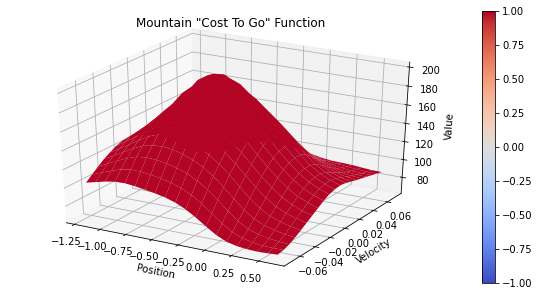

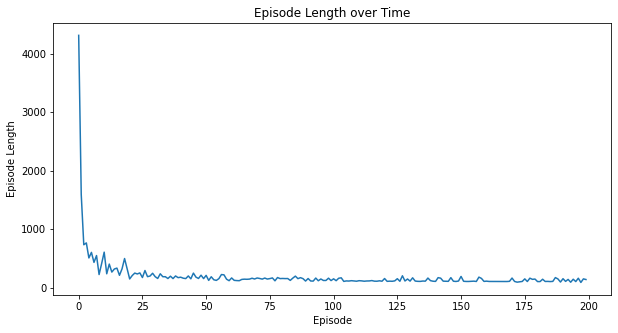

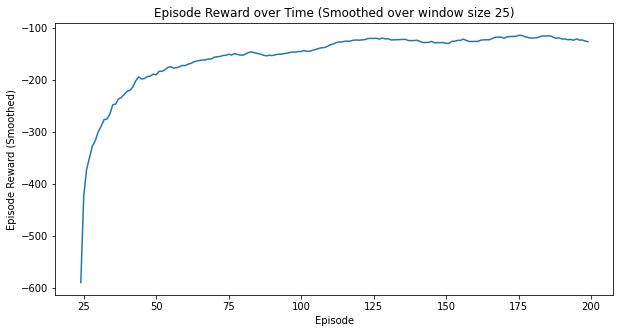

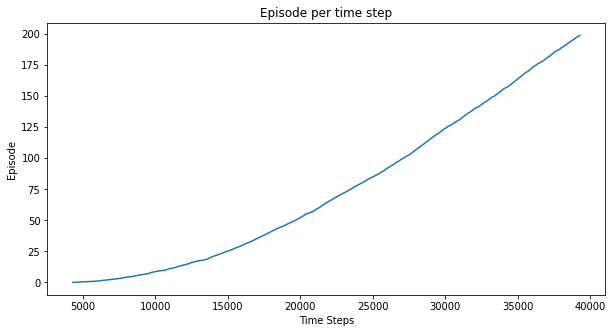

-------------------------------
| V_dbe |  -81.73821400289775  |
-------------------------------

############################################################################
Starting epoch 0 .... 
Alpha_vec value at the start of the epoch = [-0.89834014  0.25111912  0.52759067 -0.16233718 -0.38561681  0.90013019
 -0.88210072 -0.01838414 -0.76410377 -0.67052231  0.77376483  0.52854838
 -0.32962845  0.72452583 -0.49827365  0.57830256  0.23329636 -0.02508407
  0.64281508 -0.72701227 -0.1684083   0.33502653 -0.89804045  0.90278156
  0.1870468   0.71227836  0.41994977 -0.63532925 -0.63977703 -0.35970689
  0.32826778  0.35873497  0.40394484 -0.76250165  0.27841965  0.34426127
  0.76932285  0.89370946  0.75622353  0.25600778  0.73432113  0.62266008
  0.63486746 -0.77345094  0.64254725  0.14818534 -0.43605222 -0.3728753
 -0.37345395 -0.10862431]
New policy value based on previous alpha, V_vec[np] = -336.07118441724447
_____________________________LP starts_______________________________
nP_be

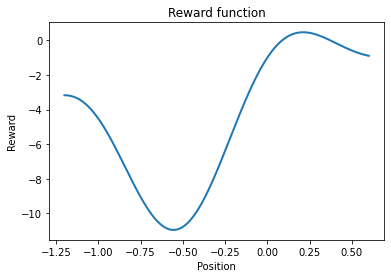

Q learning starts..........


100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


############################################################################
############################################################################
Starting epoch 1 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -1477.0159284553736
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1477.0159284553736
DBE_value based on old alpha = -868.3833370503457
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.

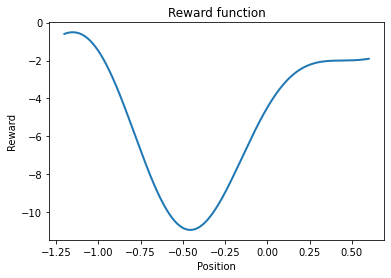

Q learning starts..........


100%|██████████| 20/20 [04:02<00:00, 12.12s/it]


############################################################################
############################################################################
Starting epoch 2 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -1979.9517733355515
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1652.730293982265
DBE_value based on old alpha = -883.8183688330889
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. 

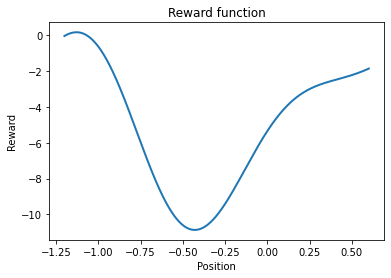

Q learning starts..........


100%|██████████| 20/20 [04:22<00:00, 13.12s/it]


############################################################################
############################################################################
Starting epoch 3 .... 
Alpha_vec value at the start of the epoch = [ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -1894.9293347214666
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1661.1235041749044
DBE_value based on old alpha = -869.2229907660412
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.

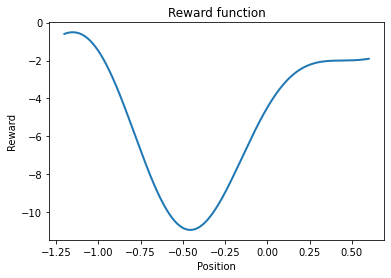

Q learning starts..........


100%|██████████| 20/20 [02:30<00:00,  7.55s/it]


############################################################################
############################################################################
Starting epoch 4 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -2056.9457366677975
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1652.730293982265
DBE_value based on old alpha = -883.8183688330889
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. 

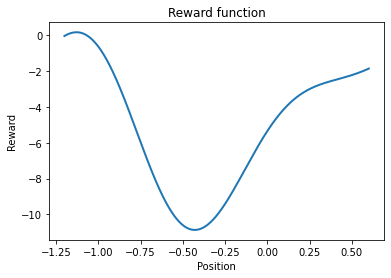

Q learning starts..........


100%|██████████| 20/20 [02:50<00:00,  8.54s/it]


############################################################################
############################################################################
Starting epoch 5 .... 
Alpha_vec value at the start of the epoch = [ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -1969.0019382429164
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1661.1235041749044
DBE_value based on old alpha = -869.2229907660412
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.

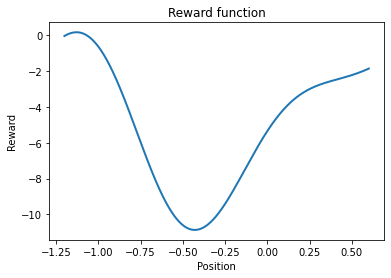

Q learning starts..........


100%|██████████| 20/20 [04:16<00:00, 12.84s/it]


############################################################################
############################################################################
Starting epoch 6 .... 
Alpha_vec value at the start of the epoch = [ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -2055.5933369831164
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1661.1235041749044
DBE_value based on old alpha = -869.2229907660412
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.

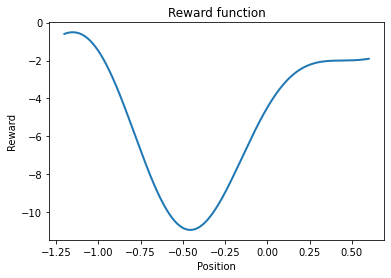

Q learning starts..........


100%|██████████| 20/20 [03:57<00:00, 11.86s/it]


############################################################################
############################################################################
Starting epoch 7 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -918.3193400707478
_____________________________LP starts_______________________________
nP_best = 7
nP_best_value based on old alpha = -918.3193400707478
DBE_value based on old alpha = -883.8183688330889
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -

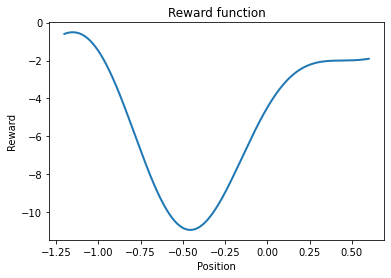

Q learning starts..........


100%|██████████| 20/20 [02:35<00:00,  7.77s/it]


############################################################################
############################################################################
Starting epoch 8 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -1599.0505774289447
_____________________________LP starts_______________________________
nP_best = 7
nP_best_value based on old alpha = -918.3193400707478
DBE_value based on old alpha = -883.8183688330889
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. 

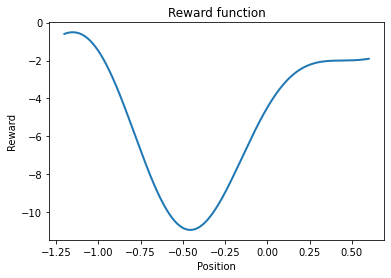

Q learning starts..........


100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


############################################################################
############################################################################
Starting epoch 9 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -2021.3428110297673
_____________________________LP starts_______________________________
nP_best = 7
nP_best_value based on old alpha = -918.3193400707478
DBE_value based on old alpha = -883.8183688330889
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. 

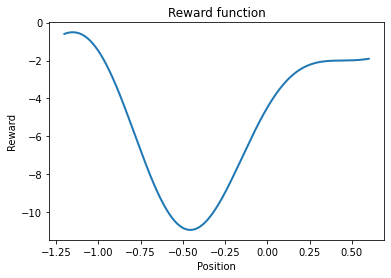

Q learning starts..........


100%|██████████| 20/20 [02:22<00:00,  7.12s/it]


############################################################################
############################################################################
Starting epoch 10 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.]
New policy value based on previous alpha, V_vec[np] = -1353.7252977443438
_____________________________LP starts_______________________________
nP_best = 7
nP_best_value based on old alpha = -918.3193400707478
DBE_value based on old alpha = -883.8183688330889
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.

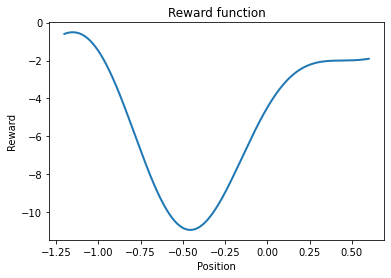

Q learning starts..........


100%|██████████| 20/20 [02:50<00:00,  8.54s/it]


In [46]:
"""
Central Code Block.
"""
# Defining Gym Environment
env = gym.make("MountainCar-v0", render_mode="rgb_array").env  

# Global_variables
featureVecDim= 50        #In 2000 paper, 26 was used.  #global_variable


# Creating observation set of the state values
observation_examples= np.array([env.observation_space.sample() for x in range(10000)])

# Normalizes state variable values. 
scaler = normalization(env, observation_examples)
normalized_data = scaler.fit_transform(observation_examples)

# Reward Basis functions Container/ Feature vector Container 
featurizer_vector = featurizer_function(normalized_data, featureVecDim)

# Defining Alpha_vec α=[α0 α1 ... αn]
alpha_vec = RandomVectorGenerator(featureVecDim)  
print("Random Alpha Vector: ")
print(alpha_vec)

# Running Q-learning code
print('\n'+'____Expert Policy Generation____'+'\n')
print("** For printing iterations with number of timesteps it took, set {print_ep_lens=True}.Highly Suggested for starting analysis.")
featurizer = state_featurizer(normalized_data)
policy_dbe, estimator_dbe = policy_f(env,scaler,featurizer,print_ep_lens=False) 

# IRL Main Code
reward_fn, alpha_vec = irl(env, alpha_vec, featurizer_vector,scaler,featurizer,
                           normalized_data,featureVecDim, policy_dbe)


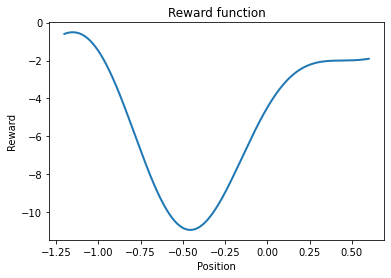

Q-learning starts:


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


Final results in graphs and 3D visualization:


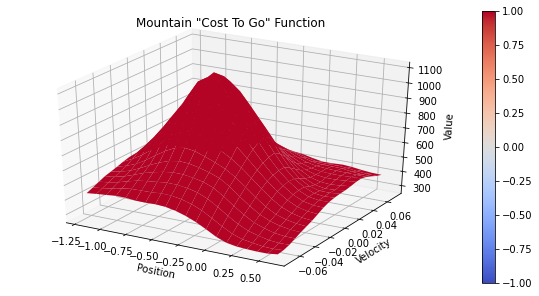

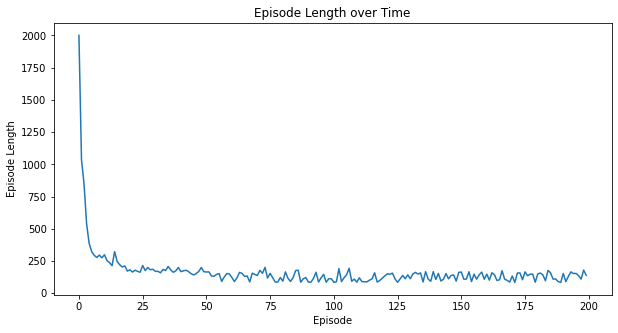

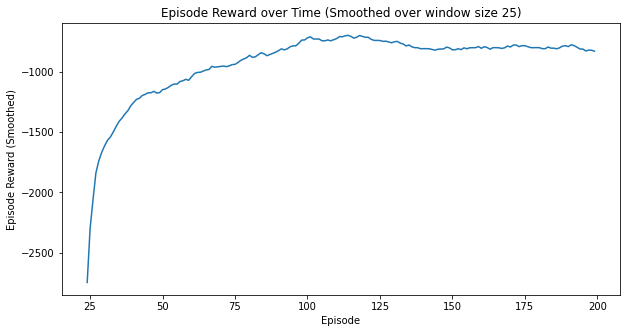

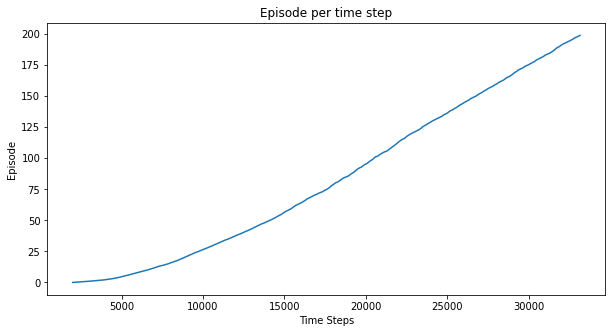

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [47]:
"""
Code Block generating stats for agent trained through learnt reward function.
"""
estimator_f = Estimator(env, scaler, featurizer)
reward_plot(alpha_vec,featurizer_vector,scaler)
print("Q-learning starts:")
"""
** For printing iterations with number of timesteps required, set {print_ep_details=True} in q_learning_testing_rewards().
Highly Suggested for starting analysis.
"""
success = q_learning_testing_rewards(env, estimator_f, reward_fn , num_episodes=200,render=True,ep_details=False)

print("Final results in graphs and 3D visualization:")
plot_cost_to_go_mountain_car(env, estimator_f)
plot_episode_stats(success, smoothing_window=25)

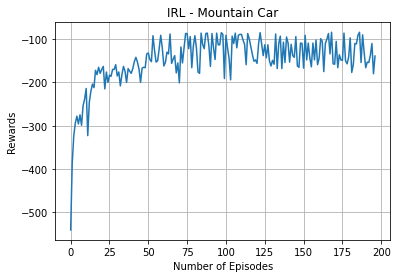

<Figure size 432x288 with 0 Axes>

In [69]:
plt.plot(-success[0][3:200])
plt.grid()
plt.xlabel('Number of Episodes')
plt.ylabel('Rewards')
plt.title('IRL - Mountain Car')
plt.show()
plt.close()
plt.savefig('rewards.pdf', format='pdf')

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


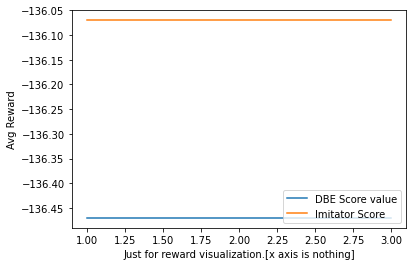

Expert policy score   |  -136.47
Imitator policy score |  -136.07


In [48]:
a,b = compare_results(env,estimator_f,estimator_dbe,num_test_trajs=100,epsilon_test=0.0)

# Comments on the Final results

- The reward function learnt may be different everytime. The reason is the issue of degeneracy & is clearly explained in the [IRL](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf) paper. 


- The Ideal results that is expected is `Expert policy score >= Imitator Policy score`. The **expert score** ranges between `[-150,-100]` and the **imitator score** must be as near to the Expert score indicating it learnt as great the imitator. But, that's not the case everytime. There are cases where:
    - Imitator Score is quite worse compared to Expert Score.
    - Imitator score is better than Expert Score.
    - Expert score is lower than -180.
    - Reward function learning diverges. (very rare but happens with some hyperparameter combinations)


- The main reason behind the exception cases is the fact that the starting position of the car is random between [-0.6,-0.4], which causes _variations_ in the trajectory data. As we used a linear approximator, its not good a function approximator compared to neural networks. The two ways to make sure such cases occur the least are:
    - Change the random start state line in the environment code. (Optional - To be clear, all results were generated on non-edited mountain car env)
    - Increase the value of `num_trajectories`. (Optimal observed was 10)

# Further Work:

- Need to use `l1 norm` in the LP optimization in addition with the original optimization. It was explained in the paper that it may help solve the key issue of degeneracy, the existance of large set of reward functions for which the observed policy is optimal.


- Need to normalize learnt reward function beetween `[-1,0]`. I believe that bounding the reward function may help in better learning of reward function.